In [1]:
import sys
import os
import itertools

import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import plotutils as pu
import util


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Matplotlib config

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
conn = "linw"
preproc = "dicer"
modelname = "AB"
configs = ["ns_1_mreg_3_msub_0_nf_32", "ns_2_mreg_3_msub_0_nf_32", "ns_3_mreg_3_msub_0_nf_32",
           "ns_4_mreg_3_msub_0_nf_32", "ns_5_mreg_3_msub_0_nf_32"]

In [4]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
nt = ds.y.shape[-1]

### FC similarity

In [7]:
def get_fc_similarity(preproc, configs, model, conn):
    nreg = 68
    nsub = 100
    nsamples = 50
    nconf = len(configs)
    
    runs = np.array([util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp") 
                     for config in configs])    
    pc = np.zeros((nconf, nsub, nsamples))
    
    for i, config in enumerate(configs):
        fc = np.load(
            f"../run/hcp/hcp100_{conn}_{preproc}/model{model}/{config}/run{runs[i]:02d}/simulations/fc.npz")
        pc[i] = fc['similarity']   
        
    return pc


fc_pc = get_fc_similarity(preproc, configs, modelname, conn)

In [8]:
fc_pc.shape

(5, 100, 50)

/tmp/ipykernel_4676/1166039941.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


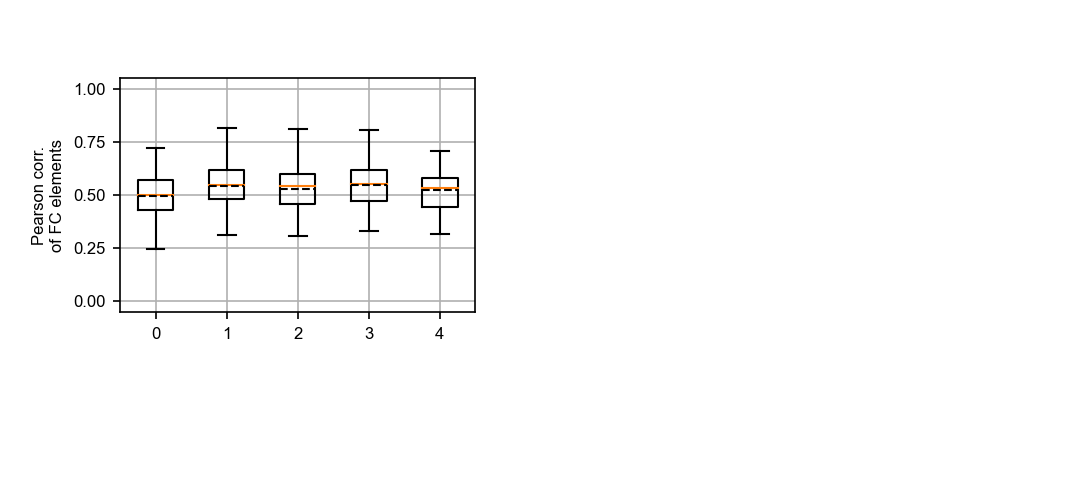

In [12]:
def plot_fc_similarity(ax, pc, nss):
    nconf, nsub, nsamples = pc.shape
    space = 1
    
    plt.boxplot([np.mean(pc[i], axis=1) for i in range(nconf)], positions=np.r_[0:nconf],
                showfliers=False, showmeans=True, meanline=True, meanprops={'color': 'k'})

    plt.ylabel('Pearson corr.\nof FC elements')
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.grid()
    
#     labelpos = np.concatenate([np.r_[:nconns], np.r_[:nconns] + nconns + space])
#     labels = np.concatenate([connlabels, connlabels])
    
#     plt.xticks(labelpos, labels, rotation='vertical')
#     plt.xlabel("Connectome", labelpad=5)
    
#     plt.grid(axis='y', zorder=-10)
#     pu.bottomleft_spines(ax)
    
#     plt.text(1.5, 1.2, "Model with\nexternal input", ha='center', va='center', fontsize=8)
#     plt.text(nconns+space+1.5, 1.2, "Model without\nexternal input", ha='center', va='center', fontsize=8)


def add_newline(s):
    return s[:s.rfind(" ")] + '\n' + s[s.rfind(" ")+1:]
    
def plot_pvals(ax, pvals, connlabels, modlabels):
    plt.title("p-values")
    plt.imshow(np.log10(pvals.T+1e-10), vmin=-20, vmax=4, cmap='Reds_r', aspect='auto')
    for i in range(n):
        for j in range(n):
            if j > i:
                ptext = f"{pvals[i,j]:.1e}" if pvals[i,j] >= 1e-10 else "< 1e-10"
                plt.text(i, j, ptext, ha='center', va='center', fontsize=6)

    labels = [c for m in modellabels for c in connlabels]
    plt.xticks(np.r_[:n], labels, rotation='vertical')
    plt.yticks(np.r_[:n], labels);
    
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    plt.xlim(-0.5,6.5)
    plt.ylim(7.5,0.5)    
    
    plt.text(1.5, 11.7, modlabels[0], ha='center', va='center')
    plt.text(5., 11.7, modlabels[1], ha='center', va='center')
    plt.plot([-0.3, 3.3], [11., 11], color='k', clip_on=False)
    plt.plot([3.7, 6.3], [11., 11], color='k', clip_on=False)
    
    
    plt.text(-3, 2,   add_newline(modlabels[0]), ha='center', va='center', rotation='vertical')
    plt.text(-3, 5.8, add_newline(modlabels[1]), ha='center', va='center', rotation='vertical')
    plt.plot([-2.5, -2.5], [0.7, 3.3], color='k', clip_on=False)
    plt.plot([-2.5, -2.5], [3.7, 7.3], color='k', clip_on=False)
    

labels = ["Std", "Std+hom", "Log", "Log+hom"]
    
plt.figure(figsize=(7.0,3.0), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.6, width_ratios=[1,1], right=0.98, left=0.1,
                       top=0.86, bottom=0.34)

ax = plt.subplot(gs[0])
plot_fc_similarity(ax, fc_pc, np.r_[1:6])

# ax = plt.subplot(gs[1])
# plot_pvals(ax, pvals, connlabels, ["With external input", "Without external input"])

plt.tight_layout()
bg = pu.Background(visible=False)
# plt.savefig("img/Fig_HCP-ns.pdf")

## Statistics

In [8]:
x = fc_pc.reshape((2*len(conns), -1))

n = len(x)
pvals = np.full((n,n), np.nan)

for i in range(n):
    for j in range(i+1, n):
        tval, pvals[i,j] = stats.ttest_ind(x[i], x[j])

In [32]:
modellabels = ["With input", "Without input"]
connlabels = ["Std", "Std+hom", "Log", "Log+hom"]
# labels = [m + ", " + c for m in modellabels for c in connlabels]
labels = [c for m in modellabels for c in connlabels]

(7.5, 0.5)

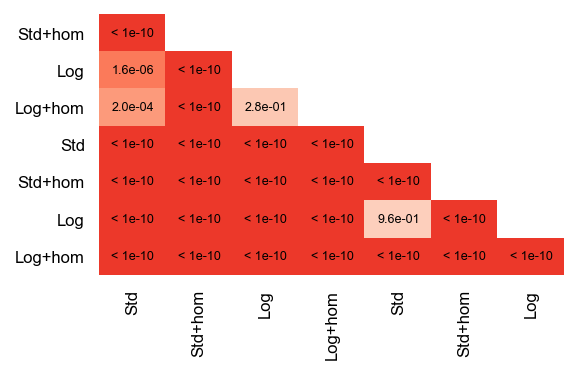

In [46]:
# current_cmap = matplotlib.cm.get_cmap()
# current_cmap.set_bad(color='0.7')


In [11]:
for i, l in enumerate(labels):
    print(f"{l:25}:   {np.mean(x[i]):.5f}")

With input, Std          :   0.52923
With input, Std+hom      :   0.55931
With input, Log          :   0.53884
With input, Log+hom      :   0.53672
Without input, Std       :   0.17754
Without input, Std+hom   :   0.23717
Without input, Log       :   0.17748
Without input, Log+hom   :   0.21083
